In [ ]:
# Voting Ensemble for Classification
import nltk # please download wordnet and stopwords if not already downloaded 

import pandas as pd
import numpy as np

from nltk.corpus import wordnet
from nltk.corpus import stopwords

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.decomposition import NMF
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score,precision_score,recall_score

In [12]:
# Import data and perform train-test split

a=pd.read_csv('/Users/ssaeed/Documents/final_claims_0205.csv')


nltk.download('stopwords')
nltk.download('wordnet')

claim=a['claim_text']
label=a['Ineligibility']

ineleg=a[a['Ineligibility']==1]
eleg=a[a['Ineligibility']==0]

# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
claim_tr, claim_tst, label_tr, label_tst = train_test_split(claim, label, test_size = 0.2, random_state = 0)

# Show the results of the split
print ("Training set has {} samples.".format(claim_tr.shape[0]))
print ("Testing set has {} samples.".format(claim_tst.shape[0]))

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>
[nltk_data] Error loading wordnet: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>
Training set has 468 samples.
Testing set has 117 samples.


## Upsampling

In [109]:
from sklearn.utils import resample

eleg = resample(eleg,replace=True,n_samples=100*len(ineleg),random_state=12)

full=pd.concat([eleg,ineleg])

In [37]:
claim=full['claim_text']
label=full['Ineligibility']

# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
claim_tr, claim_tst, label_tr, label_tst = train_test_split(claim, label, test_size = 0.2, random_state = 0)

# Show the results of the split
print ("Training set has {} samples.".format(claim_tr.shape[0]))
print ("Testing set has {} samples.".format(claim_tst.shape[0]))

Training set has 35552 samples.
Testing set has 8888 samples.


In [38]:
#Stemming and Lemmatization

stemmer = SnowballStemmer("english", ignore_stopwords=True)
lemmer=LancasterStemmer()
lemma=WordNetLemmatizer()


class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: ([lemma.lemmatize(w) for w in analyzer(doc)]) 

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

SCV = StemmedCountVectorizer(ngram_range=(1,2),stop_words='english',max_df=0.2,min_df=2)

LCV=LemmaCountVectorizer(stop_words='english',ngram_range=(1,2),max_features=2000,max_df=0.3,min_df=3)

In [180]:
# create the sub models
from sklearn.metrics import roc_auc_score


estimators = []
model1 = LogisticRegression(C=0.02,penalty='l2',class_weight={0:1,1:100})

estimators.append(('logistic', model1))


text_ensemble_lemmatized = Pipeline([('vectorizer', LCV), ('tfidf', TfidfTransformer(norm='l2',use_idf=True,smooth_idf=True)), 
                             ('svm', model1)])

# # create the ensemble model
from time import time

start=time()

text_ensemble_lemmatized.fit(claim_tr,label_tr)
predicted=text_ensemble_lemmatized.predict(claim_tst)
#predicted3=text_ensemble_lemmatized.predict_proba(claim)[:,1]

# from sklearn.metrics import f1_score

# print(round(f1_score(label_tst,predicted,average='binary'),3))
# print(round(precision_score(label_tst,predicted,average='binary'),3))
print(round(recall_score(label_tst,predicted,average='binary'),3))
# print(time()-start)
# print(sum(predicted3<0.1))

0.989


CPU times: user 48.4 ms, sys: 5.94 ms, total: 54.3 ms
Wall time: 52.2 ms


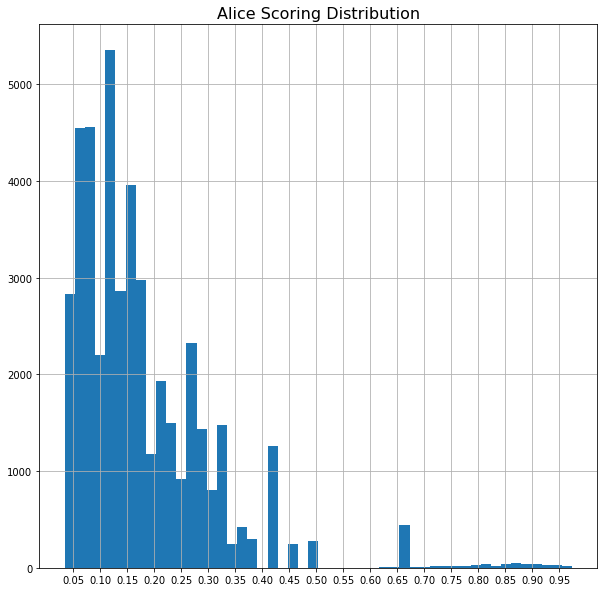

In [178]:
%%time

predicted3=pd.Series(predicted3)


from matplotlib import pyplot as plt 
from pylab import xticks
import numpy as np
import matplotlib.ticker as ticker

fig,ax=plt.subplots()
predicted3.hist(ax=ax,bins=50,figsize=(10,10))

plt.xticks([0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,.45,0.5,0.55,0.6,0.65,.7,0.75,0.8,0.85,0.9,0.95])
plt.title('Alice Scoring Distribution', fontsize=16)

In [179]:
predicted3=text_ensemble_lemmatized.predict_proba(claim)

e=[]

for i in range(len(predicted3)):
    
    e.append(round(predicted3[i][1],3))

full['alice_score'] = e
full.to_csv('/Users/ssaeed/Documents/0219_alice_scores.csv')